Apply feature engeneering on the training set which reduces the features from 25 to 15  

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/feature_engineered_data_v2.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFIFA version distribution:")
print(df['fifa_version'].value_counts().sort_index())
print(f"\nTarget distribution:")
print(df['big_potential'].value_counts())

Dataset shape: (41458, 17)

FIFA version distribution:
fifa_version
17.0    8889
18.0    8814
19.0    8777
20.0    8091
21.0    6887
Name: count, dtype: int64

Target distribution:
big_potential
0    31162
1    10296
Name: count, dtype: int64


In [3]:
# Define temporal splits
train_versions = [17.0, 18.0, 19.0,20.0]
val_version = 21.0
test_version = 21.0

# Split data by FIFA version
df_train = df[df['fifa_version'].isin(train_versions)]
df_val = df[df['fifa_version'] == val_version]
df_test = df[df['fifa_version'] == test_version]

print(f"Train (FIFA 17-20): {len(df_train)} samples")
print(f"Validation (FIFA 21): {len(df_val)} samples")
print(f"Test (FIFA 21): {len(df_test)} samples")

Train (FIFA 17-20): 34571 samples
Validation (FIFA 21): 6887 samples
Test (FIFA 21): 6887 samples


In [4]:
# All columns except fifa_version and big_potential are features
feature_columns = [col for col in df.columns if col not in ['fifa_version', 'big_potential']]
target = 'big_potential'

print(f"Number of features: {len(feature_columns)}")
print(f"Features: {feature_columns}")

# Prepare datasets
X_train = df_train[feature_columns]
y_train = df_train[target]

X_val = df_val[feature_columns]
y_val = df_val[target]

X_test = df_test[feature_columns]
y_test = df_test[target]

Number of features: 15
Features: ['age', 'mentality_interceptions', 'defending', 'defending_standing_tackle', 'defending_sliding_tackle', 'attacking_heading_accuracy', 'skill_dribbling', 'attacker_position', 'skill_ball_control', 'midfielder_position', 'attacking_finishing', 'attacking_volleys', 'attacking_short_passing', 'mentality_positioning', 'shooting']


In [5]:
from sklearn.model_selection import train_test_split
# Stratified split: 10% labeled, 90% unlabeled from training data
X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(
    X_train, y_train, 
    test_size=0.8,  # 90% unlabeled
    stratify=y_train, 
    random_state=42
)

# Create unlabeled labels (-1 for semi-supervised algorithms)
y_unlabeled = np.full(len(y_unlabeled_true), -1)

# Combine for semi-supervised training
X_train_ssl = np.vstack([X_labeled.values, X_unlabeled.values])
y_train_ssl = np.concatenate([y_labeled.values, y_unlabeled])

print(f"Labeled samples: {len(y_labeled)} ({len(y_labeled)/len(y_train)*100:.1f}%)")
print(f"Unlabeled samples: {len(y_unlabeled)} ({len(y_unlabeled)/len(y_train)*100:.1f}%)")

Labeled samples: 6914 (20.0%)
Unlabeled samples: 27657 (80.0%)


In [6]:
print(type(y_train_ssl))
print(type(X_train_ssl))
X_val_array = X_val.values if hasattr(X_val, 'values') else X_val
print(type(X_val_array))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_ssl_scaled = scaler.fit_transform(X_train_ssl)
X_val_array_scaled = scaler.transform(X_val_array)
X_labeled_scaled = scaler.transform(X_labeled.to_numpy())

In [8]:
print("Class distribution across splits:")
print(f"Train total: {y_train.value_counts().to_dict()}")
print(f"Labeled only: {y_labeled.value_counts().to_dict()}")
print(f"Validation: {y_val.value_counts().to_dict()}")
print(f"Test: {y_test.value_counts().to_dict()}")

Class distribution across splits:
Train total: {0: 25968, 1: 8603}
Labeled only: {0: 5193, 1: 1721}
Validation: {0: 5194, 1: 1693}
Test: {0: 5194, 1: 1693}


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, roc_auc_score, accuracy_score,
    precision_score, recall_score
)
from xgboost import XGBClassifier as xgb


#baseline = xgb(
#    n_estimators=300,
#    max_depth=4,
#    learning_rate=0.05,
#    subsample=0.8,
#    colsample_bytree=0.8,
#    reg_alpha=0.1,
#    reg_lambda=1.0,
#    scale_pos_weight=3,    
#    eval_metric="logloss",
#    tree_method="hist",
#    random_state=42
#)
baseline = xgb(
    n_estimators=250,      # Balanced number of trees
    max_depth=3,            # Shallower to prevent overfitting
    learning_rate=0.03,     # Conservative learning rate
    subsample=0.7,          # Aggressive subsampling
    colsample_bytree=0.7,
    reg_alpha=0.5,          # Higher regularization
    reg_lambda=2.0,
    scale_pos_weight=3,    
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)
baseline.fit(X_labeled, y_labeled)
# Predictions on validation set
y_val_pred = baseline.predict(X_val)
y_val_proba = baseline.predict_proba(X_val)[:, 1]

# Calculate metrics
print("="*60)
print("BASELINE MODEL - Validation Set (FIFA 21) Metrics")
print("="*60)
print(f"\nAccuracy:  {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall:    {recall_score(y_val, y_val_pred):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_val_proba):.4f}")

print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_val, y_val_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*60)
print("Confusion Matrix:")
print("-"*60)
cm = confusion_matrix(y_val, y_val_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual BP        {cm[1,0]:5d}  {cm[1,1]:5d}")

BASELINE MODEL - Validation Set (FIFA 21) Metrics

Accuracy:  0.6634
Precision: 0.3913
Recall:    0.6645
F1 Score:  0.4926
ROC-AUC:   0.7232

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.86      0.66      0.75      5194
   Big Potential       0.39      0.66      0.49      1693

        accuracy                           0.66      6887
       macro avg       0.62      0.66      0.62      6887
    weighted avg       0.74      0.66      0.69      6887

------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------
                  Predicted
                  No BP    BP
Actual No BP      3444   1750
Actual BP          568   1125


In [10]:
# Evaluate self-training model on validation set (FIFA 21)
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, roc_auc_score, accuracy_score,
    precision_score, recall_score
)

#self-Training classifier
from sklearn.semi_supervised import SelfTrainingClassifier
from xgboost import XGBClassifier as xgb
xgb_baseline = xgb(
    n_estimators=250,      # Balanced number of trees
    max_depth=3,            # Shallower to prevent overfitting
    learning_rate=0.03,     # Conservative learning rate
    subsample=0.7,          # Aggressive subsampling
    colsample_bytree=0.7,
    reg_alpha=0.5,          # Higher regularization
    reg_lambda=2.0,
    scale_pos_weight=3,    
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)
#xgb_baseline = xgb(
 #   n_estimators=300,
  #  max_depth=4,
   # learning_rate=0.05,
    #subsample=0.8,
    #colsample_bytree=0.8,
    #reg_alpha=0.1,
    #reg_lambda=1.0,
    #scale_pos_weight=3,    
    #eval_metric="logloss",
    #tree_method="hist",
    #random_state=42
#)

self_training = SelfTrainingClassifier(
    xgb_baseline,
    threshold=0.9,     # XGBoost gives good confidence scores
    max_iter=2,
    verbose=1
)

self_training.fit(X_train_ssl_scaled, y_train_ssl)
# Predictions on validation set
y_ssl_pred = self_training.predict(X_val_array_scaled)
y_ssl_proba = self_training.predict_proba(X_val_array_scaled)[:, 1]

# Calculate metrics
print("="*60)
print("SELF-TRAINING MODEL - Validation Set (FIFA 21) Metrics")
print("="*60)
print(f"\nAccuracy:  {accuracy_score(y_val, y_ssl_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_ssl_pred):.4f}")
print(f"Recall:    {recall_score(y_val, y_ssl_pred):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_ssl_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_ssl_proba):.4f}")

print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_val, y_ssl_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*60)
print("Confusion Matrix:")
print("-"*60)
cm = confusion_matrix(y_val, y_ssl_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual BP        {cm[1,0]:5d}  {cm[1,1]:5d}")



End of iteration 1, added 599 new labels.
End of iteration 2, added 753 new labels.
SELF-TRAINING MODEL - Validation Set (FIFA 21) Metrics

Accuracy:  0.6611
Precision: 0.3907
Recall:    0.6763
F1 Score:  0.4952
ROC-AUC:   0.7212

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.86      0.66      0.74      5194
   Big Potential       0.39      0.68      0.50      1693

        accuracy                           0.66      6887
       macro avg       0.63      0.67      0.62      6887
    weighted avg       0.75      0.66      0.68      6887

------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------
                  Predicted
                  No BP    BP
Actual No BP      3408   1786
Actual BP          548   1145


In [11]:
y_labeled_pred = self_training.predict(X_labeled_scaled)
y_labeled_proba = self_training.predict_proba(X_labeled_scaled)[:, 1]

# Calculate metrics on original labeled data
print("="*60)
print("SELF-TRAINING MODEL - Training Set Metrics (Original Labeled Data)")
print("="*60)
print(f"\nLabeled samples: {len(y_labeled)}")
print(f"\nAccuracy:  {accuracy_score(y_labeled, y_labeled_pred):.4f}")
print(f"Precision: {precision_score(y_labeled, y_labeled_pred):.4f}")
print(f"Recall:    {recall_score(y_labeled, y_labeled_pred):.4f}")
print(f"F1 Score:  {f1_score(y_labeled, y_labeled_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_labeled, y_labeled_proba):.4f}")

print("\n" + "-"*60)
print("Classification Report:")
print("-"*60)
print(classification_report(y_labeled, y_labeled_pred, target_names=['No Big Potential', 'Big Potential']))

print("-"*60)
print("Confusion Matrix:")
print("-"*60)
cm = confusion_matrix(y_labeled, y_labeled_pred)
print(f"                  Predicted")
print(f"                  No BP    BP")
print(f"Actual No BP     {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual BP        {cm[1,0]:5d}  {cm[1,1]:5d}")

SELF-TRAINING MODEL - Training Set Metrics (Original Labeled Data)

Labeled samples: 6914

Accuracy:  0.6885
Precision: 0.4259
Recall:    0.7234
F1 Score:  0.5362
ROC-AUC:   0.7730

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                  precision    recall  f1-score   support

No Big Potential       0.88      0.68      0.77      5193
   Big Potential       0.43      0.72      0.54      1721

        accuracy                           0.69      6914
       macro avg       0.65      0.70      0.65      6914
    weighted avg       0.77      0.69      0.71      6914

------------------------------------------------------------
Confusion Matrix:
------------------------------------------------------------
                  Predicted
                  No BP    BP
Actual No BP      3515   1678
Actual BP          476   1245


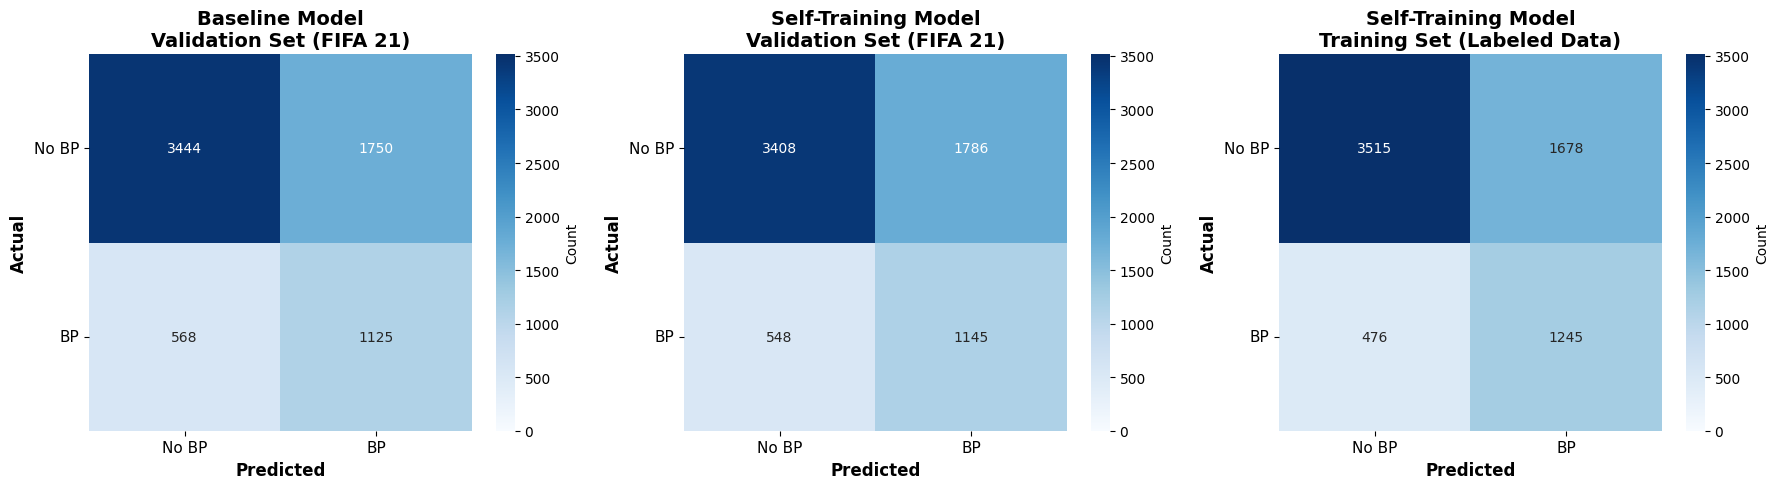

CONFUSION MATRIX SUMMARY

1. Baseline Model - Validation Set:
   True Negatives (TN):  3444 | False Positives (FP):  1750
   False Negatives (FN):   568 | True Positives (TP):  1125

2. Self-Training Model - Validation Set:
   True Negatives (TN):  3408 | False Positives (FP):  1786
   False Negatives (FN):   548 | True Positives (TP):  1145

3. Self-Training Model - Training Set:
   True Negatives (TN):  3515 | False Positives (FP):  1678
   False Negatives (FN):   476 | True Positives (TP):  1245


In [12]:
# Visualize confusion matrices using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get confusion matrices from previous evaluations
# 1. Baseline model on validation set
y_val_pred_baseline = baseline.predict(X_val)
cm_baseline_val = confusion_matrix(y_val, y_val_pred_baseline)

# 2. Self-training model on validation set
cm_ssl_val = confusion_matrix(y_val, y_ssl_pred)

# 3. Self-training model on training set (labeled data)
cm_ssl_train = confusion_matrix(y_labeled, y_labeled_pred)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define colormap
cmap = 'Blues'

# 1. Baseline Model - Validation Set
sns.heatmap(cm_baseline_val, annot=True, fmt='d', cmap=cmap, ax=axes[0], 
            cbar_kws={'label': 'Count'}, vmin=0, vmax=max(cm_baseline_val.max(), cm_ssl_val.max(), cm_ssl_train.max()))
axes[0].set_title('Baseline Model\nValidation Set (FIFA 21)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['No BP', 'BP'], fontsize=11)
axes[0].set_yticklabels(['No BP', 'BP'], fontsize=11, rotation=0)

# 2. Self-Training Model - Validation Set
sns.heatmap(cm_ssl_val, annot=True, fmt='d', cmap=cmap, ax=axes[1], 
            cbar_kws={'label': 'Count'}, vmin=0, vmax=max(cm_baseline_val.max(), cm_ssl_val.max(), cm_ssl_train.max()))
axes[1].set_title('Self-Training Model\nValidation Set (FIFA 21)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(['No BP', 'BP'], fontsize=11)
axes[1].set_yticklabels(['No BP', 'BP'], fontsize=11, rotation=0)

# 3. Self-Training Model - Training Set
sns.heatmap(cm_ssl_train, annot=True, fmt='d', cmap=cmap, ax=axes[2], 
            cbar_kws={'label': 'Count'}, vmin=0, vmax=max(cm_baseline_val.max(), cm_ssl_val.max(), cm_ssl_train.max()))
axes[2].set_title('Self-Training Model\nTraining Set (Labeled Data)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[2].set_xticklabels(['No BP', 'BP'], fontsize=11)
axes[2].set_yticklabels(['No BP', 'BP'], fontsize=11, rotation=0)

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*80)
print("CONFUSION MATRIX SUMMARY")
print("="*80)

print("\n1. Baseline Model - Validation Set:")
print(f"   True Negatives (TN): {cm_baseline_val[0,0]:5d} | False Positives (FP): {cm_baseline_val[0,1]:5d}")
print(f"   False Negatives (FN): {cm_baseline_val[1,0]:5d} | True Positives (TP): {cm_baseline_val[1,1]:5d}")

print("\n2. Self-Training Model - Validation Set:")
print(f"   True Negatives (TN): {cm_ssl_val[0,0]:5d} | False Positives (FP): {cm_ssl_val[0,1]:5d}")
print(f"   False Negatives (FN): {cm_ssl_val[1,0]:5d} | True Positives (TP): {cm_ssl_val[1,1]:5d}")

print("\n3. Self-Training Model - Training Set:")
print(f"   True Negatives (TN): {cm_ssl_train[0,0]:5d} | False Positives (FP): {cm_ssl_train[0,1]:5d}")
print(f"   False Negatives (FN): {cm_ssl_train[1,0]:5d} | True Positives (TP): {cm_ssl_train[1,1]:5d}")


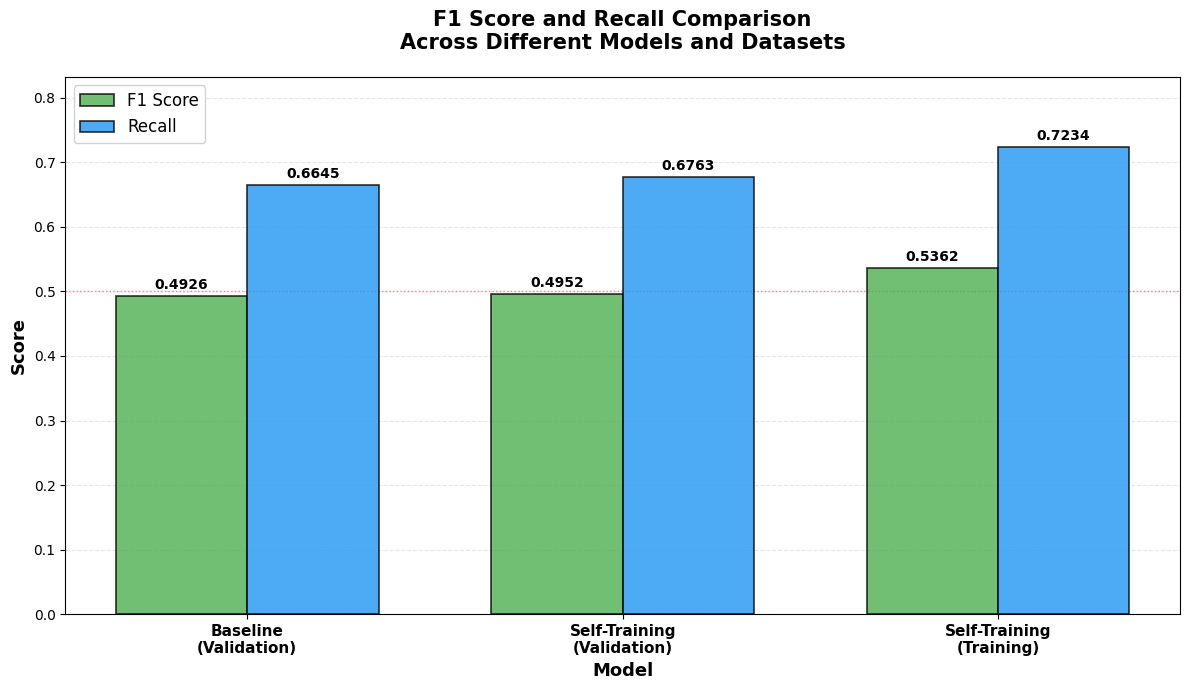

METRICS COMPARISON: F1 Score and Recall

Model                               F1 Score        Recall          Improvement    
--------------------------------------------------------------------------------
Baseline (Validation)               0.4926          0.6645          Baseline       
Self-Training (Validation)          0.4952          0.6763          F1: +0.0027, R: +0.0118
Self-Training (Training)            0.5362          0.7234          F1: +0.0436, R: +0.0589

KEY INSIGHTS:
✓ Self-Training improves F1 Score on validation by 0.0027 (0.55%)
✓ Self-Training improves Recall on validation by 0.0118 (1.78%)


In [13]:
# Bar chart comparing F1 Score and Recall for the three models
from sklearn.metrics import f1_score, recall_score

# Calculate metrics for all three models
# 1. Baseline Model - Validation Set
f1_baseline_val = f1_score(y_val, y_val_pred_baseline)
recall_baseline_val = recall_score(y_val, y_val_pred_baseline)

# 2. Self-Training Model - Validation Set
f1_ssl_val = f1_score(y_val, y_ssl_pred)
recall_ssl_val = recall_score(y_val, y_ssl_pred)

# 3. Self-Training Model - Training Set
f1_ssl_train = f1_score(y_labeled, y_labeled_pred)
recall_ssl_train = recall_score(y_labeled, y_labeled_pred)

# Prepare data for bar chart
models = ['Baseline\n(Validation)', 'Self-Training\n(Validation)', 'Self-Training\n(Training)']
f1_scores = [f1_baseline_val, f1_ssl_val, f1_ssl_train]
recall_scores = [recall_baseline_val, recall_ssl_val, recall_ssl_train]

# Create bar chart
x = np.arange(len(models))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

# Create bars
bars1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score', color='#4CAF50', alpha=0.8, edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, recall_scores, width, label='Recall', color='#2196F3', alpha=0.8, edgecolor='black', linewidth=1.2)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)

# Customize the plot
ax.set_xlabel('Model', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('F1 Score and Recall Comparison\nAcross Different Models and Datasets', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11, fontweight='bold')
ax.set_ylim([0, max(max(f1_scores), max(recall_scores)) * 1.15])
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Add horizontal line at y=0.5 for reference
ax.axhline(y=0.5, color='red', linestyle=':', linewidth=1, alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()

# Print comparison table
print("="*80)
print("METRICS COMPARISON: F1 Score and Recall")
print("="*80)
print(f"\n{'Model':<35} {'F1 Score':<15} {'Recall':<15} {'Improvement':<15}")
print("-" * 80)

# Baseline
print(f"{'Baseline (Validation)':<35} {f1_baseline_val:<15.4f} {recall_baseline_val:<15.4f} {'Baseline':<15}")

# Self-Training Validation
f1_improvement_val = f1_ssl_val - f1_baseline_val
recall_improvement_val = recall_ssl_val - recall_baseline_val
print(f"{'Self-Training (Validation)':<35} {f1_ssl_val:<15.4f} {recall_ssl_val:<15.4f} "
      f"F1: {f1_improvement_val:+.4f}, R: {recall_improvement_val:+.4f}")

# Self-Training Training
f1_improvement_train = f1_ssl_train - f1_baseline_val
recall_improvement_train = recall_ssl_train - recall_baseline_val
print(f"{'Self-Training (Training)':<35} {f1_ssl_train:<15.4f} {recall_ssl_train:<15.4f} "
      f"F1: {f1_improvement_train:+.4f}, R: {recall_improvement_train:+.4f}")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
if f1_improvement_val > 0:
    print(f"✓ Self-Training improves F1 Score on validation by {f1_improvement_val:.4f} ({f1_improvement_val/f1_baseline_val*100:.2f}%)")
else:
    print(f"✗ Self-Training decreases F1 Score on validation by {abs(f1_improvement_val):.4f} ({abs(f1_improvement_val)/f1_baseline_val*100:.2f}%)")

if recall_improvement_val > 0:
    print(f"✓ Self-Training improves Recall on validation by {recall_improvement_val:.4f} ({recall_improvement_val/recall_baseline_val*100:.2f}%)")
else:
    print(f"✗ Self-Training decreases Recall on validation by {abs(recall_improvement_val):.4f} ({abs(recall_improvement_val)/recall_baseline_val*100:.2f}%)")
